In [ ]:
# ======================
# IMPORTS & CONFIGURATION
# ======================

from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from tifffile import imread

# This notebook is in src/, so root is ".."
ROOT = Path("..")

# Local imports
from unet import UNet

# Inference Visualization Notebook

This notebook visualizes model predictions on train/test data.
- Load trained UNet model
- Generate predictions for sample images
- Compare predictions with ground truth masks
- Visualize RGB, NIR, and overlay views

In [ ]:
# ======================
# CONFIGURATION
# ======================

# Model checkpoint path
CKPT_PATH = ROOT / "outputs" / "best_unet.pth"

# Dataset split to evaluate
SPLIT = "test"  # "train" or "test"

# Visualization options
SHOW_NIR = True
SHOW_OVERLAY = True
OVERLAY_ALPHA = 0.35

# Model configuration
NUM_CLASSES = 10
IGNORE_INDEX = 255

# Class names for reference
CLASS_NAMES = {
    0: "no_data",
    1: "clouds",
    2: "artificial",
    3: "cultivated",
    4: "broadleaf",
    5: "coniferous",
    6: "herbaceous",
    7: "natural_soil",
    8: "permanent_snow",
    9: "water",
}

## Helper Functions

Image preprocessing and model utilities.

In [ ]:
def ensure_hwc(x: np.ndarray) -> np.ndarray:
    """Ensure image is in HWC format."""
    if x.ndim == 3 and x.shape[0] in (3, 4, 5, 6) and x.shape[1] > 32 and x.shape[2] > 32:
        return np.transpose(x, (1, 2, 0))
    return x

def stretch01(band: np.ndarray, p_low=2, p_high=98) -> np.ndarray:
    """Percentile stretch to [0, 1]."""
    lo, hi = np.percentile(band, (p_low, p_high))
    return np.clip((band - lo) / (hi - lo + 1e-6), 0, 1)

def preprocess_image(img_hwc: np.ndarray) -> torch.Tensor:
    """
    Preprocess image for model inference.
    Converts to CHW format, normalizes bands, and adds batch dimension.
    """
    img = img_hwc.astype(np.float32)
    for c in range(img.shape[-1]):
        img[..., c] = stretch01(img[..., c], 2, 98)
    x = torch.from_numpy(np.transpose(img, (2, 0, 1))).float().unsqueeze(0)
    return x

## Data Loading Functions

Load image-mask pairs from disk.

In [ ]:
def read_pair(split: str, index: int = 0, filename: str | None = None):
    """
    Load an image-mask pair from disk.
    
    Parameters:
      - split: "train" or "test"
      - index: file index (if filename is None)
      - filename: specific file to load
      
    Returns:
      - filename, image array (HWC), mask array
    """
    images_dir = ROOT / "dataset" / split / "images"
    masks_dir = ROOT / "dataset" / split / "masks"

    img_files = sorted(list(images_dir.glob("*.tif"))) + sorted(list(images_dir.glob("*.tiff")))
    if len(img_files) == 0:
        raise FileNotFoundError(f"No TIFF images found in: {images_dir}")

    if filename is None:
        img_path = img_files[index]
    else:
        img_path = images_dir / filename
        if not img_path.exists():
            raise FileNotFoundError(f"Image not found: {img_path}")

    msk_path = masks_dir / img_path.name
    if not msk_path.exists():
        raise FileNotFoundError(f"Mask not found for: {img_path.name}")

    img = ensure_hwc(imread(str(img_path)))
    msk = imread(str(msk_path)).astype(np.int64)

    return img_path.name, img, msk

## Model Loading & Inference

Load trained model and generate predictions.

In [ ]:
def load_model():
    """Load trained UNet model from checkpoint."""
    device = torch.device("cpu")
    model = UNet(in_channels=4, num_classes=NUM_CLASSES, base_channels=32).to(device)
    state = torch.load(CKPT_PATH, map_location=device)
    model.load_state_dict(state)
    model.eval()
    return model, device

def predict_mask(model, device, img_hwc: np.ndarray) -> np.ndarray:
    """
    Generate segmentation prediction for an image.
    
    Returns:
      - Predicted class mask (H, W)
    """
    x = preprocess_image(img_hwc).to(device)
    with torch.no_grad():
        logits = model(x)
        pred = torch.argmax(logits, dim=1)[0]
    return pred.cpu().numpy().astype(np.int64)

## Visualization Functions

Plot predictions with RGB, NIR, and ground truth comparisons.

In [ ]:
def plot_triplet(title_prefix, rgb, nir, gt, pred):
    """
    Visualize RGB, NIR, ground truth, and prediction side-by-side.
    
    Parameters:
      - title_prefix: prefix for subplot titles
      - rgb, nir: display images
      - gt, pred: ground truth and predicted masks
    """
    cols = 3 + (1 if SHOW_NIR else 0) + (1 if SHOW_OVERLAY else 0)
    fig, axes = plt.subplots(1, cols, figsize=(4.5 * cols, 5))

    k = 0
    
    # RGB
    axes[k].imshow(rgb)
    axes[k].set_title(f"{title_prefix} RGB")
    axes[k].axis("off")
    k += 1

    # NIR (optional)
    if SHOW_NIR:
        axes[k].imshow(nir, cmap="gray")
        axes[k].set_title(f"{title_prefix} NIR")
        axes[k].axis("off")
        k += 1

    # Ground truth mask
    axes[k].imshow(gt)
    axes[k].set_title(f"{title_prefix} Ground Truth")
    axes[k].axis("off")
    k += 1

    # Prediction
    axes[k].imshow(pred)
    axes[k].set_title(f"{title_prefix} Prediction")
    axes[k].axis("off")
    k += 1

    # Overlay (optional)
    if SHOW_OVERLAY:
        axes[k].imshow(rgb)
        axes[k].imshow(pred, alpha=OVERLAY_ALPHA)
        axes[k].set_title(f"{title_prefix} Overlay")
        axes[k].axis("off")

    plt.tight_layout()
    plt.show()

## Example Inference

Load a sample image and visualize model prediction.

In [ ]:
def visualize_one(split="test", index=0, filename=None):
    """
    Visualize model prediction for a single image.
    
    Parameters:
      - split: "train" or "test"
      - index: file index (if filename is None)
      - filename: specific file to load
    """
    name, img, gt = read_pair(split, index=index, filename=filename)

    # Extract bands
    b = img[..., 0].astype(np.float32)
    g = img[..., 1].astype(np.float32)
    r = img[..., 2].astype(np.float32)
    nir = img[..., 3].astype(np.float32)

    # Create RGB visualization
    rgb = np.stack([stretch01(r), stretch01(g), stretch01(b)], axis=-1)
    nir_disp = stretch01(nir)

    # Load model and predict
    model, device = load_model()
    pred = predict_mask(model, device, img)

    print(f"[{split.upper()}] {name}")
    print(f"  Ground truth classes: {np.unique(gt)}")
    print(f"  Predicted classes: {np.unique(pred)}")

    plot_triplet(f"{split.upper()} {name}", rgb, nir_disp, gt, pred)

[test] 10087.tif
GT labels: [2 3 4 5 6 9]
Pred labels: [2 3 4 5 6 9]


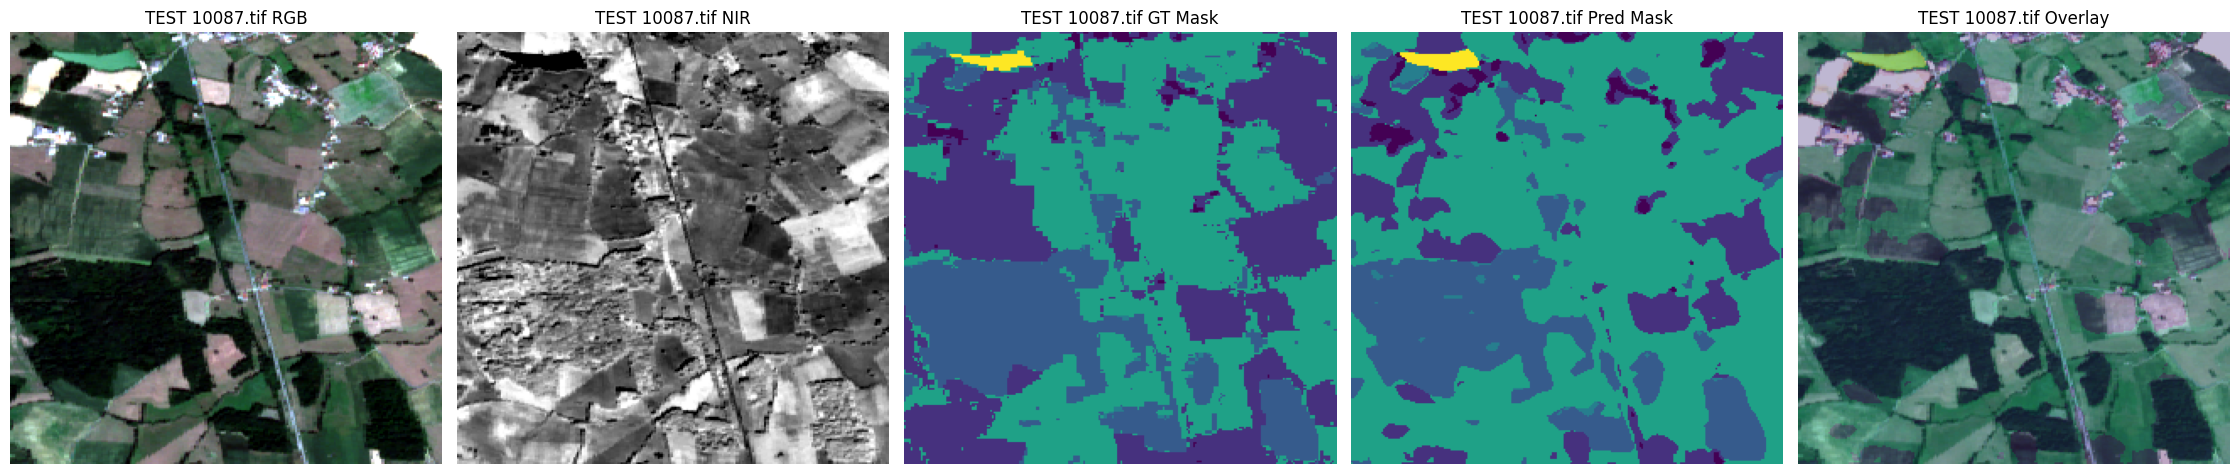

In [ ]:
# Choose visualization: by index OR filename
visualize_one(split=SPLIT, index=0)
# visualize_one(split=SPLIT, filename="1.tif")